In [1]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib as mpl

CWD = os.path.abspath(os.path.curdir)
print("CWD: '{}'".format(CWD))

ODIR = os.path.join(CWD, "output", "")
if not os.path.exists(ODIR):
    os.makedirs(ODIR)
    print("Created output directory: '{}'".format(ODIR))

par_dir = os.path.join(CWD, os.path.pardir)
if par_dir not in sys.path:
    sys.path.append(par_dir)
    print("Added parent directory: '{}'".format(par_dir))

import bhem
import bhem.basics
import bhem.utils
import bhem.disks
import bhem.radiation
import bhem.spectra
from bhem.constants import MSOL, H_PLNK, K_BLTZ, SPLC, MPRT, MELC, QELC

np.seterr(over='ignore');

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times']})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

FS_TITLE = 20
FS_LABEL = 16

plt.rcParams.update({'axes.titlesize': FS_TITLE})
plt.rcParams.update({'axes.labelsize': FS_LABEL})
plt.rcParams.update({'xtick.labelsize': FS_LABEL})
plt.rcParams.update({'ytick.labelsize': FS_LABEL})


CWD: '/Users/lzkelley/Programs/bhem/notebooks'
Added parent directory: '/Users/lzkelley/Programs/bhem/notebooks/..'


# Parameters

In [3]:
MASS = 1.0e2 * MSOL
# FEDD = 3.0e-5
FEDD = 2.9e-5
NRAD = 100

adaf = bhem.disks.ADAF(MASS, NRAD, fedd=FEDD)
mdot, _ = bhem.utils.mdot_fedd(MASS, None, FEDD)
print(adaf)

Mass: 1.00e+02 [Msol]
Mdot: 6.4e-11 [Msol/yr],  Fedd: 2.9e-05


# Profiles

## Primitives

In [ ]:
# Assume temperature of the electrons is negligible compared to ions
#    then via NY95b Eq. 2.16:
temp_ion = 6.66e12 * adaf.beta_gp * adaf._c3 / adaf.rs

# For now, define electron temperature as fixed factor lower than ion
# temp_elc = np.ones_like(temp_ion) * np.min(temp_ion)
# temp_elc = 1e10 * np.ones_like(temp_ion)
# temp_elc = np.minimum(temp_elc, temp_ion/2.0)

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])

ax.set(xscale='log', xlabel='Radius [$R_s$]', yscale='log', ylabel='Density')
ax.plot(adaf.rs, adaf.dens, 'k-', lw=2.0, alpha=0.8)

tw = ax.twinx(); tw.set(yscale='log'); tw.set_ylabel('Velocity', color='blue')
tw.plot(adaf.rs, adaf.vel_ff, 'b-')
tw.plot(adaf.rs, adaf.vel_snd, 'b--')
tw.plot(adaf.rs, np.fabs(adaf.vel_rad), 'b:', lw=2.0)

side = 'right'
tw = ax.twinx(); tw.set(yscale='log')
tw.set_ylabel('Temp', color='red')
tw.yaxis.set_label_position(side)
tw.yaxis.set_ticks_position(side)
tw.spines[side].set_position(('axes', 1.2))
# tw.plot(adaf.rs, temp_ion*K_BLTZ/(MPRT*SPLC*SPLC), 'r-')
# tw.plot(adaf.rs, temp_elc*K_BLTZ/(MELC*SPLC*SPLC), 'r--')
tw.plot(adaf.rs, temp_ion, 'r-')
# tw.plot(adaf.rs, temp_elc, 'r--')

plt.show()

## Heating / Cooling

In [ ]:
# ne = bhem.utils.ndens_elc(adaf.dens, adaf.frac_hmass)
# ni = bhem.utils.ndens_ion(adaf.dens, adaf.frac_hmass)

# heat_ie = bhem.radiation.heating_coulomb_ie(ne, ni, temp_elc, temp_ion)

# cool_brem_ei = bhem.radiation.cooling_brems_ei(ne, temp_elc)
# cool_brem_ee = bhem.radiation.cooling_brems_ee(ne, temp_elc)

In [ ]:
# fig, ax = plt.subplots(figsize=[10, 5])
# ax.set(xscale='log', xlabel='Radius [$R_s$]', yscale='log', ylim=[1e-12, 1e3])
# ax.set_ylabel('Heating', color='red')
# tw = ax.twinx(); tw.set(yscale='log')
# tw.set_ylabel('Cooling', color='blue')

# ax.plot(adaf.rs, adaf.visc_diss, 'r-', lw=2.0, alpha=0.8)
# ax.plot(adaf.rs, heat_ie, 'r--', lw=2.0, alpha=0.8)

# tw.plot(adaf.rs, cool_brem_ei, 'b-.', lw=2.0, alpha=0.8)
# tw.plot(adaf.rs, cool_brem_ee, 'b:', lw=2.0, alpha=0.8)

# plt.show()

# [Mahadevan 1996](https://arxiv.org/abs/astro-ph/9609107)

This treatment solves for the heating/cooling based on quantities integrated over the whole region of the disk.  Specifically this means that the electron temperature ($T_e$) becomes some "effective" electron-temperature for the heating/cooling processes over the whole advection regime.

In [6]:
freqs = np.logspace(5, 25, 100)
m96 = bhem.spectra.Mahadevan96(adaf, freqs)

Electron temperature seems inconsistent (Te = 6.54e+09)!
	m: 1.00e+02, f: 2.90e-05
	Heating: 1.91e+32, Cooling: 4.22e+32, diff: 1.2146e+00
	This may mean there is an input error (e.g. mdot may be too large... or small?).


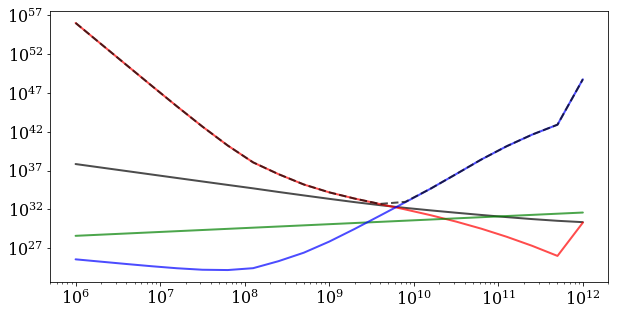

In [7]:
temps = np.logspace(6, 12, 21)
qv = []; qs = []; qb = []; qc = []
for te in temps:
    _qv, _qs, _qb, _qc = m96._heat_cool(te)
    qv.append(_qv); qs.append(_qs); qb.append(_qb); qc.append(_qc);
    
qv = np.array(qv); qs = np.array(qs); qb = np.array(qb); qc = np.array(qc)
fig, ax = plt.subplots(figsize=[10, 5])
ax.set(xscale='log', yscale='log')

ax.plot(temps, qv, 'k-', alpha=0.7, lw=2.0)
ax.plot(temps, qs, 'r-', alpha=0.7, lw=2.0)
ax.plot(temps, qb, 'g-', alpha=0.7, lw=2.0)
ax.plot(temps, qc, 'b-', alpha=0.7, lw=2.0)
ax.plot(temps, qs+qb+qc, 'k--', alpha=0.7, lw=2.0)

ylim = np.array(ax.get_ylim())
ylim[1] = np.minimum(ylim[1], 1e80)
ax.set_ylim(ylim)

plt.show()

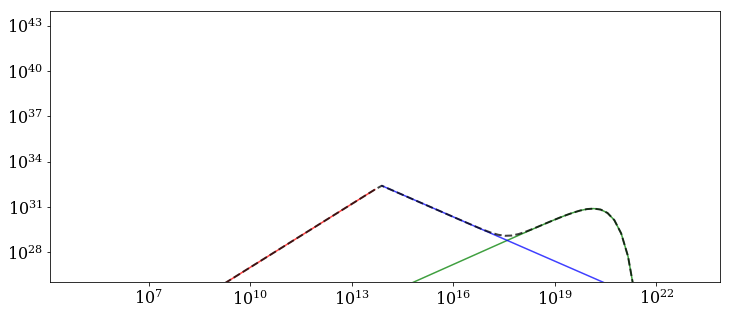

In [8]:
lv_synch = m96.spectrum_synch
lv_brems = m96.spectrum_brems
lv_compt = m96.spectrum_compt

lv = lv_synch + lv_brems + lv_compt

fig, ax = plt.subplots(figsize=[12, 5])
ax.set(xscale='log', yscale='log', ylim=[1e26, 1e44])

def _plot(xx, yy, color='k', alpha=0.75, **kwargs):
    idx = (yy > 0.0)
    ax.plot(xx[idx], yy[idx], color=color, alpha=alpha, **kwargs)
    return

_plot(freqs, freqs*lv_synch, color='r')
_plot(freqs, freqs*lv_brems, color='g')
_plot(freqs, freqs*lv_compt, color='b')
_plot(freqs, freqs*lv, ls='--', lw=2.0)

plt.show()

## Total Luminosity And Efficiency

/Users/lzkelley/Programs/bhem/bhem/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  mid = 0.5 * (np.log10(arr[1:]) + np.log10(arr[:-1]))


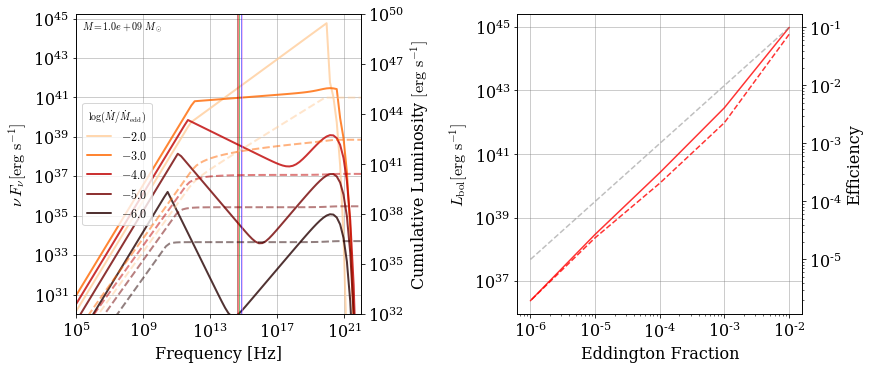

Saved to '/Users/lzkelley/Programs/bhem/notebooks/output/lum-eff_thin-adaf_mdot'


In [9]:
_MASS = 1e9 * MSOL

fig, axes = plt.subplots(figsize=[12, 5], ncols=2)
plt.subplots_adjust(wspace=0.55, left=0.08, right=0.92, top=0.96)

for ax in axes:
    ax.set(xscale='log', yscale='log')
    ax.grid(True, which='major', axis='both', c='0.5', alpha=0.5)


ax = axes[0]
ax.set(xlim=[1e5, 1e22], xlabel='Frequency [Hz]', 
       ylabel='$\\nu \, F_\\nu [\mathrm{erg \,\, s}^{-1}]$')
tw = ax.twinx(); tw.set(yscale='log', ylabel='Cumulative Luminosity $[\mathrm{erg \,\, s}^{-1}]$')

fedds = np.logspace(-6, -2, 5)[::-1]
lums = np.zeros_like(fedds)

cmap = mpl.cm.get_cmap('gist_heat_r')
colors = [cmap(xx) for xx in np.linspace(0.1, 0.9, fedds.size)]
ymax = 0.0

for ii, fe in enumerate(fedds):
    label = '${:+.1f}$'.format(np.log10(fe))
    cc = colors[ii]
    kw = dict(color=cc, lw=2.0, label=label)

    _adaf = bhem.disks.ADAF(_MASS, 100, fedd=fe)
    _spec = bhem.spectra.Mahadevan96(_adaf, freqs)
    lum = _spec.spectrum
    
    ax.plot(freqs, freqs*lum, ls='-', alpha=0.8, **kw)
    ymax = np.maximum(np.max(freqs*lum), ymax)
    
    lum_mid = bhem.utils.log_midpoints(lum)
    freqs_mid = bhem.utils.log_midpoints(freqs)
    df = np.diff(freqs)
    cumlum = np.cumsum(df * lum_mid)
    lums[ii] = cumlum[-1]
    tw.plot(freqs_mid, cumlum, alpha=0.5, ls='--', **kw)    
    
tw.set_ylim([1e32, 1e50])
ax.set_ylim([1e30, 3*ymax])
ax.text(0.02, 0.98, "$M = {:.1e} \,\, M_\odot$".format(_MASS/MSOL), transform=ax.transAxes,
         ha='left', va='top')
    
for nn, band in bhem.constants.BANDS.items():
    ax.axvline(band.freq, color=band.color, lw=1.0, alpha=0.5)

ax.legend(title="$\log(\dot{M}/\dot{M}_\mathrm{edd})$", fontsize=12, loc='center left')


ax = axes[1]
ax.set(xlabel='Eddington Fraction', 
       ylabel='$L_\mathrm{bol} [\mathrm{erg \,\, s}^{-1}]$')
tw = ax.twinx(); tw.set(yscale='log', ylabel='Efficiency')

mdot_edd = bhem.basics.eddington_accretion(_MASS)
effs = lums/(mdot_edd * fedds * SPLC**2)

ax.plot(fedds, lums, 'r-', alpha=0.8)
tw.plot(fedds, effs, 'r--', alpha=0.8)
tw.plot(fedds, np.minimum(10*fedds, 0.1), color='0.5', ls='--', alpha=0.5)

plt.show()

fname = 'lum-eff_thin-adaf_mdot'
fname = os.path.join(ODIR, fname)
fig.savefig(fname + '.pdf')
fig.savefig(fname + '.png')
print("Saved to '{}'".format(fname))